In [400]:
using PyPlot, PyCall
using JuMP, Ipopt, Statistics
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");

In [401]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

### Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [402]:
model = ClimateModel();
@time optimize_controls!(model, obj_option = "net_benefit");

Solve_Succeeded
  3.278843 seconds (3.96 M allocations: 197.228 MiB, 2.80% gc time)


In [403]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "maxTnoG" => [], "maxT" => [], "maxCO2" => [])
ρdict = Dict()
ρs = 0.:0.005:0.1

for ρ in ρs
    tmp_model = ClimateModel();
    tmp_model.economics.utility_discount_rate = ρ
    @time optimize_controls!(tmp_model, obj_option = "net_benefit");
    ρdict[ρ] = tmp_model
    
    append!(stat_dict["mitigate"], mean(tmp_model.controls.mitigate))
    append!(stat_dict["remove"], mean(tmp_model.controls.remove))
    append!(stat_dict["adapt"], mean(tmp_model.controls.adapt))
    append!(stat_dict["geoeng"], mean(tmp_model.controls.geoeng))
    append!(stat_dict["maxTnoG"], maximum(δT_no_geoeng(tmp_model)))
    append!(stat_dict["maxT"], maximum(δT(tmp_model)))
    append!(stat_dict["maxCO2"], maximum(CO₂(tmp_model)))
end

Solve_Succeeded
  0.046716 seconds (110.00 k allocations: 4.310 MiB)
Solve_Succeeded
  0.046880 seconds (109.99 k allocations: 4.310 MiB)
Solve_Succeeded
  0.043600 seconds (102.10 k allocations: 4.158 MiB)
Solve_Succeeded
  0.042538 seconds (102.25 k allocations: 4.168 MiB)
Solve_Succeeded
  0.045234 seconds (100.76 k allocations: 4.126 MiB)
Solve_Succeeded
  0.040738 seconds (100.76 k allocations: 4.126 MiB)
Solve_Succeeded
  0.043488 seconds (104.85 k allocations: 4.212 MiB)
Solve_Succeeded
  0.051402 seconds (104.70 k allocations: 4.202 MiB)
Solve_Succeeded
  0.050155 seconds (102.25 k allocations: 4.167 MiB)
Solve_Succeeded
  0.044932 seconds (102.10 k allocations: 4.158 MiB)
Solve_Succeeded
  0.040890 seconds (98.16 k allocations: 4.082 MiB)
Solve_Succeeded
  0.107020 seconds (118.03 k allocations: 4.472 MiB, 26.89% gc time)
Solve_Succeeded
  0.794129 seconds (981.66 k allocations: 21.120 MiB)
Solve_Succeeded
  1.259942 seconds (1.56 M allocations: 32.352 MiB)
Solve_Succeeded
  2

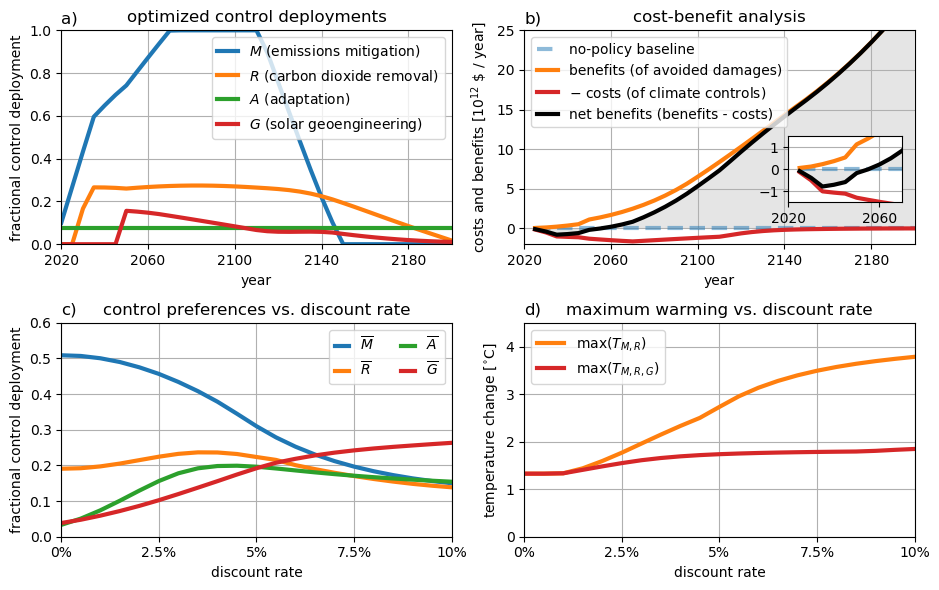

Maximum warming: 1.2839736769477197

In [413]:
fig = figure(figsize=(9.5,6.))

fig.add_subplot(2,2,1)
plot_controls(model)
legend(handlelength=1.5, loc="upper right")
add_label("a)")
xticks(model.domain[1]:40.:2200.)

ax = fig.add_subplot(2,2,2)
plot_benefits(model)
legend(handlelength=1.5, loc="upper left")
add_label("b)")
ylim([-2., 25.])
xticks(model.domain[1]:40.:2200.)

ax = fig.add_subplot(2,2,3)
plot(ρs, stat_dict["mitigate"], label=L"$\overline{M}$")
plot(ρs, stat_dict["remove"], label=L"$\overline{R}$")
plot(ρs, stat_dict["adapt"], label=L"$\overline{A}$")
plot(ρs, stat_dict["geoeng"], label=L"$\overline{G}$")
legend(ncol=2, handlelength=1.)
ylim([0, 0.6])
xlim([0., 0.1])
xticks([0., 0.025, 0.05, 0.075, 0.1], ["0%", "2.5%", "5%", "7.5%", "10%"])
grid(true)
ylabel("fractional control deployment")
title("control preferences vs. discount rate")
title("c)", loc="left")
xlabel("discount rate")

ax = fig.add_subplot(2,2,4)
plot(ρs, stat_dict["maxTnoG"], "C1", label=L"$\max(T_{M,R})$")
plot(ρs, stat_dict["maxT"], "C3", label=L"$\max(T_{M,R,G})$")
xlim([0., 0.1])
ylim([0, 4.5])
xticks([0., 0.025, 0.05, 0.075, 0.1], ["0%", "2.5%", "5%", "7.5%", "10%"])
grid(true)
legend()
title("maximum warming vs. discount rate")
title("d)", loc="left")
xlabel("discount rate")
ylabel(L"temperature change [$^{\circ}$C]")

iax = fig.add_axes([0.835, 0.655, 0.12, 0.11])
sca(iax)
plot_benefits(model)
ylabel("")
xlabel("")
ylim([-1.5, 1.5])
xlim([2020,2070])
title("")

tight_layout()
savefig("../figures/default-benefits_controls_and_benefits.pdf", dpi=150, bbox_inches="tight")

print("Maximum warming: ", maximum(δT_adapt(model)))

#### Approach 2: Avoiding damage thresholds

In [414]:
model = ClimateModel();
@time optimize_controls!(model);

Solve_Succeeded
  0.111692 seconds (191.98 k allocations: 8.779 MiB)


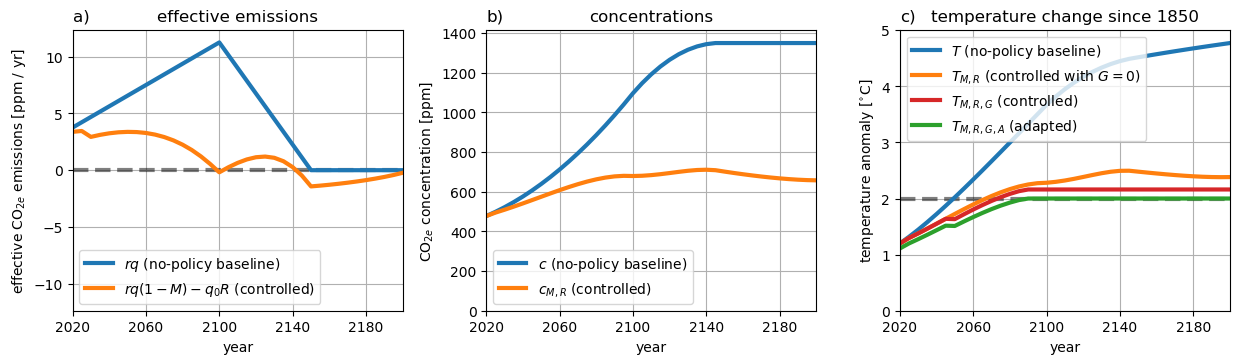

In [415]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
legend()
add_label("a)")
subplot(1,3,2)
plot_concentrations(model)
legend()
add_label("b)")
subplot(1,3,3)
plot_temperatures(model)
legend(loc="upper left")
add_label("c)")
tight_layout()
savefig("../figures/default-temp_carbon_and_temperatures.pdf", dpi=150, bbox_inches="tight")

In [416]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "mitigate_cost_limits" => [])
mitigate_cost_limits = 0.:0.05:1.0

for mitigate_cost_limit in mitigate_cost_limits
    tmp_model = ClimateModel();
    tmp_model.economics.mitigate_init = 0.
    @time m = optimize_controls!(tmp_model, obj_option = "net_benefit", mitigate_cost_limit = mitigate_cost_limit);
    
    if raw_status(m) == "Solve_Succeeded"
        append!(stat_dict["mitigate"], maximum(tmp_model.controls.mitigate))
        append!(stat_dict["remove"], maximum(tmp_model.controls.remove))
        append!(stat_dict["adapt"], maximum(tmp_model.controls.adapt))
        append!(stat_dict["geoeng"], maximum(tmp_model.controls.geoeng))
        append!(stat_dict["mitigate_cost_limits"], mitigate_cost_limit)
    end
end

Solve_Succeeded
  2.642319 seconds (2.16 M allocations: 105.792 MiB, 1.37% gc time)
Solve_Succeeded
  0.162920 seconds (234.68 k allocations: 9.747 MiB)
Solve_Succeeded
  0.087400 seconds (158.18 k allocations: 5.424 MiB)
Solve_Succeeded
  0.074829 seconds (163.01 k allocations: 5.531 MiB)
Solve_Succeeded
  0.097434 seconds (162.87 k allocations: 5.521 MiB)
Solve_Succeeded
  0.184365 seconds (158.33 k allocations: 5.434 MiB, 34.66% gc time)
Solve_Succeeded
  0.078646 seconds (148.80 k allocations: 5.230 MiB)
Solve_Succeeded
  0.058140 seconds (153.64 k allocations: 5.337 MiB)
Solve_Succeeded
  0.065044 seconds (153.49 k allocations: 5.327 MiB)
Solve_Succeeded
  0.049896 seconds (130.20 k allocations: 4.851 MiB)
Solve_Succeeded
  0.061610 seconds (120.67 k allocations: 4.646 MiB)
Solve_Succeeded
  0.069678 seconds (125.51 k allocations: 4.753 MiB)
Solve_Succeeded
  0.091220 seconds (125.36 k allocations: 4.744 MiB)
Solve_Succeeded
  0.048846 seconds (120.82 k allocations: 4.656 MiB)
Sol

In [417]:
function f_asymp(α, mitigate_cost_limit)
    idx = α .>= mitigate_cost_limit
    ret = α .^ 2. ./ (1. .- exp.(20. *(α .- mitigate_cost_limit)))
    ret[idx] .= NaN
    return ret
end
α = 0.:0.002:1.0

0.0:0.002:1.0

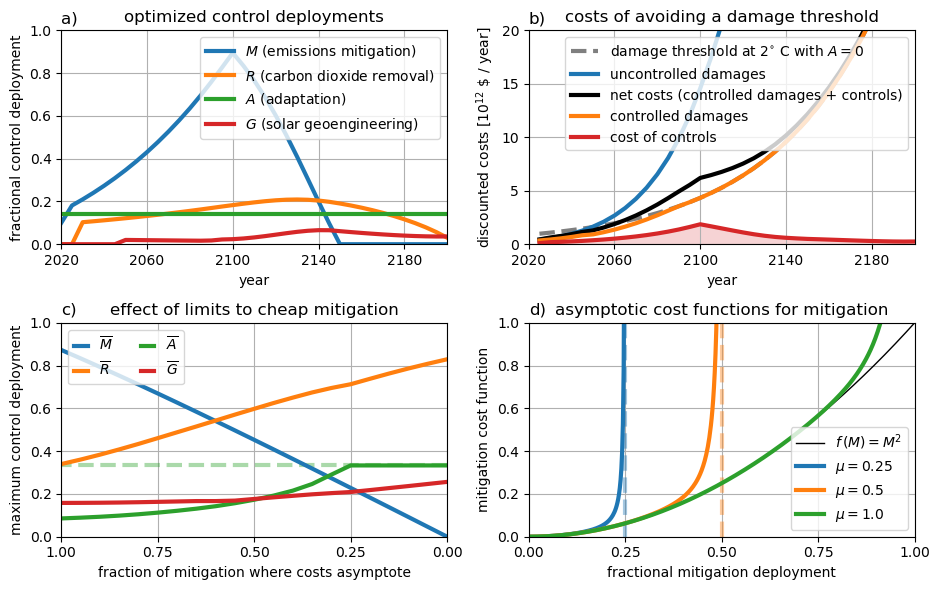

Net Present Control Costs: 54.73534601538341

In [418]:
figure(figsize=(9.5,6))

subplot(2,2,1)
plot_controls(model)
legend(loc="upper right")
add_label("a)")

subplot(2,2,2)
plot_damages(model)
legend(loc="upper right")
add_label("b)")
ylim([0, 20])

subplot(2,2,3)
plot([0., 1.], [1. /3, 1. /3], "C2--", alpha=0.4)
plot(mitigate_cost_limits, stat_dict["mitigate"], label=L"$\overline{M}$")
plot(mitigate_cost_limits, stat_dict["remove"], label=L"$\overline{R}$")
plot(mitigate_cost_limits, stat_dict["adapt"], label=L"$\overline{A}$")
plot(mitigate_cost_limits, stat_dict["geoeng"], label=L"$\overline{G}$")
legend(loc = "upper left", ncol=2, handlelength=1.)
ylim([0, 1.0])
xlim([1.0, 0.])
xticks([1., 0.75, 0.5, 0.25, 0.])
grid(true)
ylabel("maximum control deployment")
title("effect of limits to cheap mitigation")
title("c)", loc="left")
xlabel("fraction of mitigation where costs asymptote")

subplot(2,2,4)
plot([0.25, 0.25], [0, 1], "C0--", alpha=0.4)
plot([0.5, 0.5], [0, 1.], "C1--", alpha=0.4)
plot(α, α.^2, "k-", lw=1., label=L"$f\,(M) = M^{2}$")
for mitigate_cost_limit in [0.25, 0.5, 1.0]
    plot(α, f_asymp(α, mitigate_cost_limit), label=latexstring(L"$μ = $",mitigate_cost_limit))
end
xlim([0,1])
ylim([0,1])
xticks([0., 0.25, 0.5, 0.75, 1.])
legend(loc="lower right")
ylabel("mitigation cost function")
xlabel("fractional mitigation deployment")
title("asymptotic cost functions for mitigation")
title("d)", loc="left")
grid(true)

tight_layout()
savefig("../figures/default-temp_controls_and_damages.pdf", dpi=150, bbox_inches="tight")

print("Net Present Control Costs: ", discounted_total_control_cost(model))